# Transfer Learning

- We will use pretrained models, trained on a similar problem as ours and will try to fine tune it or just modify the classification layer for our output,
- we will use a `small Learning Rate` as we don't want to loss the weights of pretrained model that was trained for such a long time.

[Tensroflow Documentation for EfficientNetB4](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB4)

In [ ]:
from IPython.display import IFrame

IFrame(
  src="https://drive.google.com/file/d/1aIk8j5gbNgOwx9R-xCGHy_gTmyUTcLQj/preview",
  width=1200,
  height=600
)


## **EfficientNetB4**
- There are **`two parts of a CNN model`**, one is the **`base`** (`ConvNet` layers or Feature Extraction layers) and the 2nd is the **`top/head`** (Fully connected or `Dense` layers that do classification).
- **Usually**, **`in Transfer Learning`** we replace the `top` layers, their weights are randomly initialized from scratch, while the `ConvNet` base is kept frozen.
- But when **`Fine Tuning`**, we also update the `ConvNet` layers, with a `small learning rate`.
- (**Tip:** `Don't fine-tune all ConvNet layers at once`; start with a few top layers, if results improve then unfreeze more.)

![Basic CNN Architecture](https://miro.medium.com/v2/resize:fit:4800/format:webp/0*L97k3HW5qhlXOuae.jpg)


## Google Drive Setup (Recommended In Colab to track Model Training)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports and Setting

In [ ]:
import tensorflow as tf

if tf.test.is_gpu_available():
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
# tf.config.list_physical_devices('GPU')

[]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Data Loading

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

100%|██████████| 309M/309M [00:08<00:00, 39.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4


In [ ]:
import os
import shutil

# Path to the downloaded dataset
dataset_path = path

destination_path = "/content/datasets"


if not os.path.exists(destination_path):
    os.makedirs(destination_path)

items_to_copy = os.listdir(dataset_path)

# Copy item to the destination path
for item in items_to_copy:
    source_item_path = os.path.join(dataset_path, item)
    destination_item_path = os.path.join(destination_path, item)
    if os.path.isdir(source_item_path):

        shutil.copytree(source_item_path, destination_item_path, dirs_exist_ok=True)
    else:

        shutil.copy2(source_item_path, destination_item_path)

print("Dataset copied to:", destination_path)

Dataset copied to: /content/datasets


## Loading train/test datasets from directories
[Image Dataset from Directory in Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

In [ ]:
train_dir = "/content/datasets/Emotions Dataset/Emotions Dataset/train"
val_dir = "/content/datasets/Emotions Dataset/Emotions Dataset/test"
class_names = ['angry', 'happy', 'sad']     # must match the order of dir

## Configuration

In [ ]:
configuration = {
    "batch_size": 32,
    "image_size": 256,
    "epochs": 20,
    "learning_rate": 0.001,
    "dropout_rate": 0.0,      # 0.2
    "regularization_rate": 0.0,      # 0.01
    "N_filters": 6,
    "kernel_size": 3,
    "pool_size": 2,
    "N_strides": 1,
    "N_dense_1": 1024,
    "N_dense_2": 128,
    "num_classes": 3

}

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',    # automatically infers the labels just from dir structure, means in test folder three subfolders or classes angry/happy/sad, it'll learn automatically.
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=configuration["batch_size"],
    image_size=(configuration["image_size"], configuration["image_size"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',       # int - encoded as integers, if set to categorical, it'll be OneHot Encode
    class_names=class_names,
    color_mode='rgb',
    batch_size= configuration["batch_size"],
    image_size=(configuration["image_size"], configuration["image_size"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


## Labels

In [ ]:
for i in train_dataset.take(1):
    print(i)        # see the labels in the bottom [angry, happy, sad] ------> [0, 1, 2] integer encoding, change label_mode to categorical and see the labels again.

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[115.       , 115.       , 115.       ],
         [110.9375   , 110.9375   , 110.9375   ],
         [111.375    , 111.375    , 111.375    ],
         ...,
         [ 40.3125   ,  40.3125   ,  40.3125   ],
         [ 41.1875   ,  41.1875   ,  41.1875   ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.       , 115.       , 115.       ],
         [112.25781  , 112.25781  , 112.25781  ],
         [110.765625 , 110.765625 , 110.765625 ],
         ...,
         [ 41.683594 ,  41.683594 ,  41.683594 ],
         [ 41.847656 ,  41.847656 ,  41.847656 ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.6875   , 115.6875   , 115.6875   ],
         [113.80859  , 113.80859  , 113.80859  ],
         [110.58203  , 110.58203  , 110.58203  ],
         ...,
         [ 41.570312 ,  41.570312 ,  41.570312 ],
         [ 40.496094 ,  40.496094 ,  40.496094 ],
         [ 39.9375   ,  39.9375   ,  39.9375

## Data Visualizations

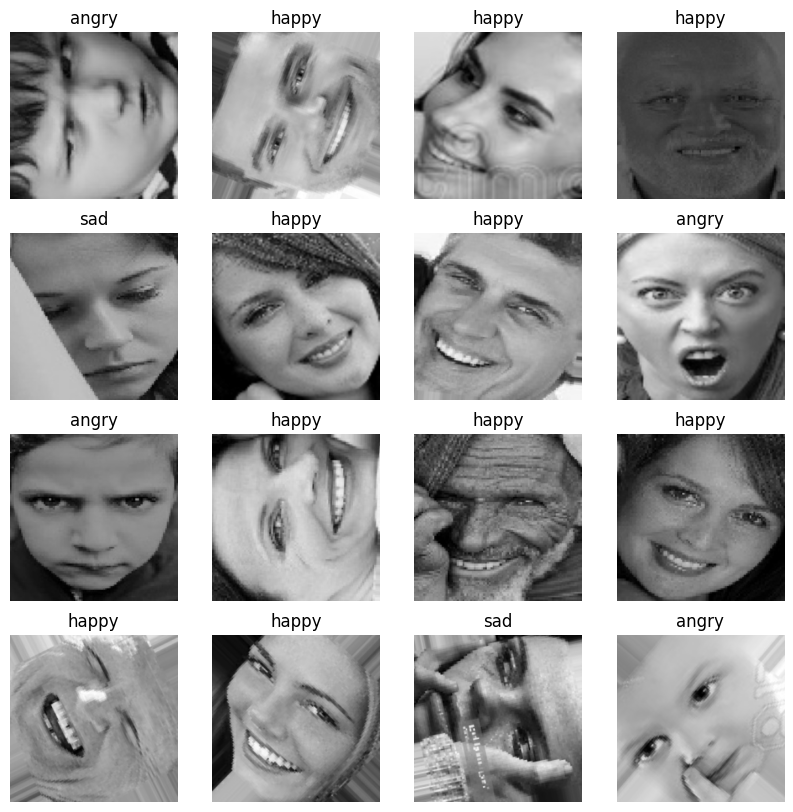

In [ ]:
plt.figure(figsize=(10, 10))

for image, label in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image[i]/255.)
        plt.title(class_names[np.argmax(label[i])])     # argmax finds the index of 1 (True) in OneHot encoded label array, you can remove it if label_mode = 'int' in Loading train/test datasets from dict
        plt.axis("off")

## Augmentation
- Augmentation brings variety to dataset.
- There is no universal combination of augmentation stratgies, generally we try them one by one and see how these affect model performance.

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

In [1]:
0.025*360

9.0

In [ ]:
data_augment = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(factor=(-0.025, 0.025)), # limits the rotation between -9 and +9 degrees, if not limitted we may have some rotation that could make happy face sad.
    RandomZoom(0.1),
    RandomContrast(factor = 0.1),

])

In [ ]:
@tf.function
def data_augmentation(image, label):
    image = data_augment(image, training = True)
    return image, label

## Data Preparation

In [ ]:
train_data = (
    train_dataset
    # .cache()    # stores data in temp cache for faster access
    .map(data_augmentation, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)     # prefetch(AUTOTUNE); Automatically prefetches optimal number of data points while model is being trained on a batch.
)

In [ ]:
val_data = (
    val_dataset
    # .cache()    # stores data in temp cache for faster access
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
val_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

## Resize Rescale

In [ ]:
from tensorflow.keras.layers import Resizing, Rescaling

resize_rescale = tf.keras.Sequential([
    Resizing(configuration["image_size"], configuration["image_size"]),
    Rescaling(1./255)
])

## Class Weights

In [ ]:
from sklearn.utils import class_weight
import numpy as np

labels = np.concatenate([y for x, y in train_data], axis=0)
class_weights = class_weight.compute_class_weight('balanced',
                                               classes=np.unique(labels.argmax(axis=1)),
                                               y=labels.argmax(axis=1))
class_weights = dict(enumerate(class_weights))

# CallBacks

## LR Rate Schedular

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)

## Early Stopping

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

## Best Model Checkpoints
- I'll use two checkpoints one to save model at each epoch so i can revert to any epoch i want and one to save only the Best Model when val accuracy improves (will be helpful in deployement).
  - `checkpoint` → for debugging (revert to any epoch)
  - `best_model_checkpoint` → for final deployment.

In [ ]:
# Creates a folder in your Google Drive for saving models
checkpoint_path = "/content/drive/MyDrive/EfficientNetEmotionModelCheckpoints/"

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path + "EfficientNet_emotion_model_epoch_{epoch:02d}.keras",
    save_best_only=False,    # save all epochs
    save_weights_only=False, # full model (not just weights)
    verbose=1
)

In [ ]:
best_model_checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/EfficientNetEmotionModelBest.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

# EfficientNet

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

In [ ]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False,            # Dense layers are not included we will add our own
    weights="imagenet",
    input_shape=(configuration['image_size'], configuration['image_size'], 3)
    # pooling=None,           # Optional, only when the top is set to False (Means we have only CovNet Layers)
    # classes=1000,         # as we set top to False (Dense layers not present)
    # classifier_activation='softmax'           # Not needed as Neurons not included
)

## Freez CovNet Layers

In [ ]:
backbone.trainable = False  # freeze backbone

## Adding Neurons

### Functional API
- Sometimes sequential layers don't connect well and model.fit() raises an error **`ValueError:`** `No gradients provided for any variable`, so if you also get that then you can run this functional Model.

**Hopefully You won't get that error as i resolved it.**

In [ ]:
# Functional API
inputs = Input(shape=(configuration['image_size'], configuration['image_size'], 3))

x = backbone(inputs, training=False)  # forward pass

x = GlobalAveragePooling2D()(x)

x = Dense(configuration['N_dense_1'], activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(configuration['N_dense_2'], activation="relu")(x)

outputs = Dense(configuration['num_classes'], activation="softmax")(x)

func_model = Model(inputs, outputs)

# Compile
func_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configuration["learning_rate"]),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

func_model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 8, 8, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,836,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

In [ ]:
history = func_model.fit(train_data,
                    validation_data=val_data,
              epochs=5
              # class_weight=class_weights,
              # callbacks=[early_stop, lr_scheduler, checkpoint_callback]#, checkpoint, best_model_checkpoint]
              )

Epoch 1/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 208s 758ms/step - accuracy: 0.6419 - loss: 0.9882 - val_accuracy: 0.7138 - val_loss: 0.6505
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 107s 499ms/step - accuracy: 0.7384 - loss: 0.6347 - val_accuracy: 0.7353 - val_loss: 0.6495
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 141s 497ms/step - accuracy: 0.7754 - loss: 0.5463 - val_accuracy: 0.7704 - val_loss: 0.5964
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 125s 583ms/step - accuracy: 0.7974 - loss: 0.4958 - val_accuracy: 0.7989 - val_loss: 0.5075
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 125s 583ms/step - accuracy: 0.8252 - loss: 0.4273 - val_accuracy: 0.7954 - val_loss: 0.5184


In [ ]:
func_model.save("/content/drive/MyDrive/Func_EmotionDetectorModelSaved.keras")

In [ ]:
func_model= tf.keras.models.load_model('/content/drive/MyDrive/Func_EmotionDetectorModelSaved.keras')

### Sequential API

In [ ]:
from tensorflow.keras.layers import Lambda

seq_model = tf.keras.Sequential([
    Input(shape = (configuration['image_size'], configuration['image_size'], 3)),
    # Lambda(preprocess_input),
    backbone,
    GlobalAveragePooling2D(),
    Dense( configuration["N_dense_1"], activation = "relu"),
    BatchNormalization(),
    Dense( configuration["N_dense_2"], activation = "relu"),
    Dense( configuration["num_classes"], activation = "softmax"),

    ])
seq_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 8, 8, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,836,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

In [ ]:
metrics=["accuracy", TopKCategoricalAccuracy(k=2, name="top2_acc"), "precision", "recall"]

In [ ]:
seq_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=configuration["learning_rate"]),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
historyy = seq_model.fit(train_data,
                    validation_data=val_data,
              epochs=10,
              # class_weight=class_weights,
              callbacks=[early_stop, lr_scheduler, checkpoint, best_model_checkpoint]
              )

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.6336 - loss: 1.0319
Epoch 1: saving model to /content/drive/MyDrive/EfficientNetEmotionModelCheckpoints/EfficientNet_emotion_model_epoch_01.keras

Epoch 1: val_accuracy did not improve from 0.84504
213/213 ━━━━━━━━━━━━━━━━━━━━ 194s 692ms/step - accuracy: 0.6338 - loss: 1.0310 - val_accuracy: 0.7313 - val_loss: 0.6047 - learning_rate: 0.0010
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7439 - loss: 0.6127
Epoch 2: saving model to /content/drive/MyDrive/EfficientNetEmotionModelCheckpoints/EfficientNet_emotion_model_epoch_02.keras

Epoch 2: val_accuracy did not improve from 0.84504
213/213 ━━━━━━━━━━━━━━━━━━━━ 106s 494ms/step - accuracy: 0.7439 - loss: 0.6126 - val_accuracy: 0.7520 - val_loss: 0.5827 - learning_rate: 0.0010
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.7694 - loss: 0.5439
Epoch 3: saving model to /content/drive/MyDrive/EfficientNetEmotionModelCheckpoints/Effici

## Performance Visualization

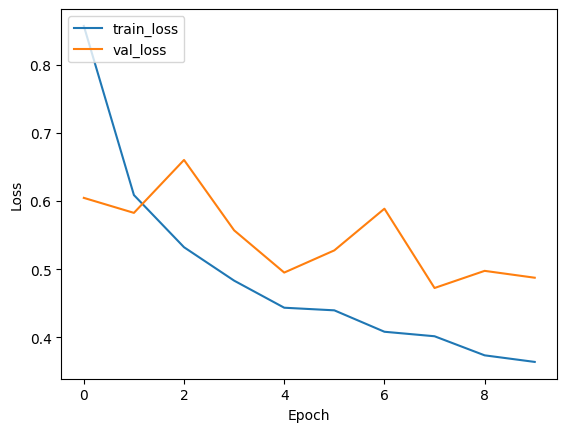

In [ ]:
plt.plot(historyy.history['loss'], label='train_loss')
plt.plot(historyy.history['val_loss'], label='val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

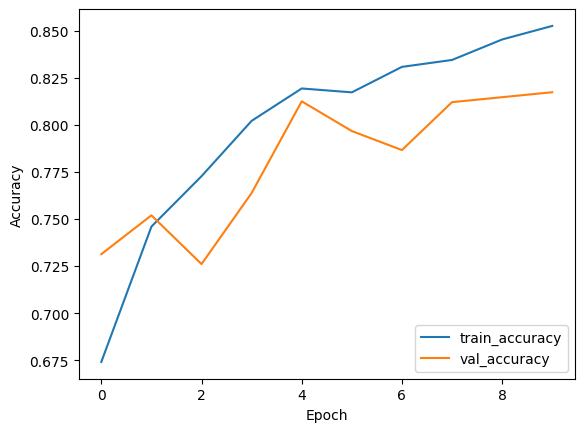

In [ ]:
plt.plot(historyy.history['accuracy'], label='train_accuracy')
plt.plot(historyy.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Evaluation
- If you run evaluation right after training stopped, the model will evaluate with the wights of the most recent epoch,
- So, it is a good practice to **`load the Best Model`** saved **`with the Best Weights`** and **`then Run the Evaluation`**.

In [ ]:
from tensorflow import keras
model_emo_best = keras.models.load_model('/content/drive/MyDrive/EfficientNetEmotionModelBest.keras')

In [ ]:
model_emo_best.evaluate(val_data)

72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 226ms/step - accuracy: 0.8436 - loss: 0.4454


[0.43280211091041565, 0.8450394868850708]

### Actual vs Predicted

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


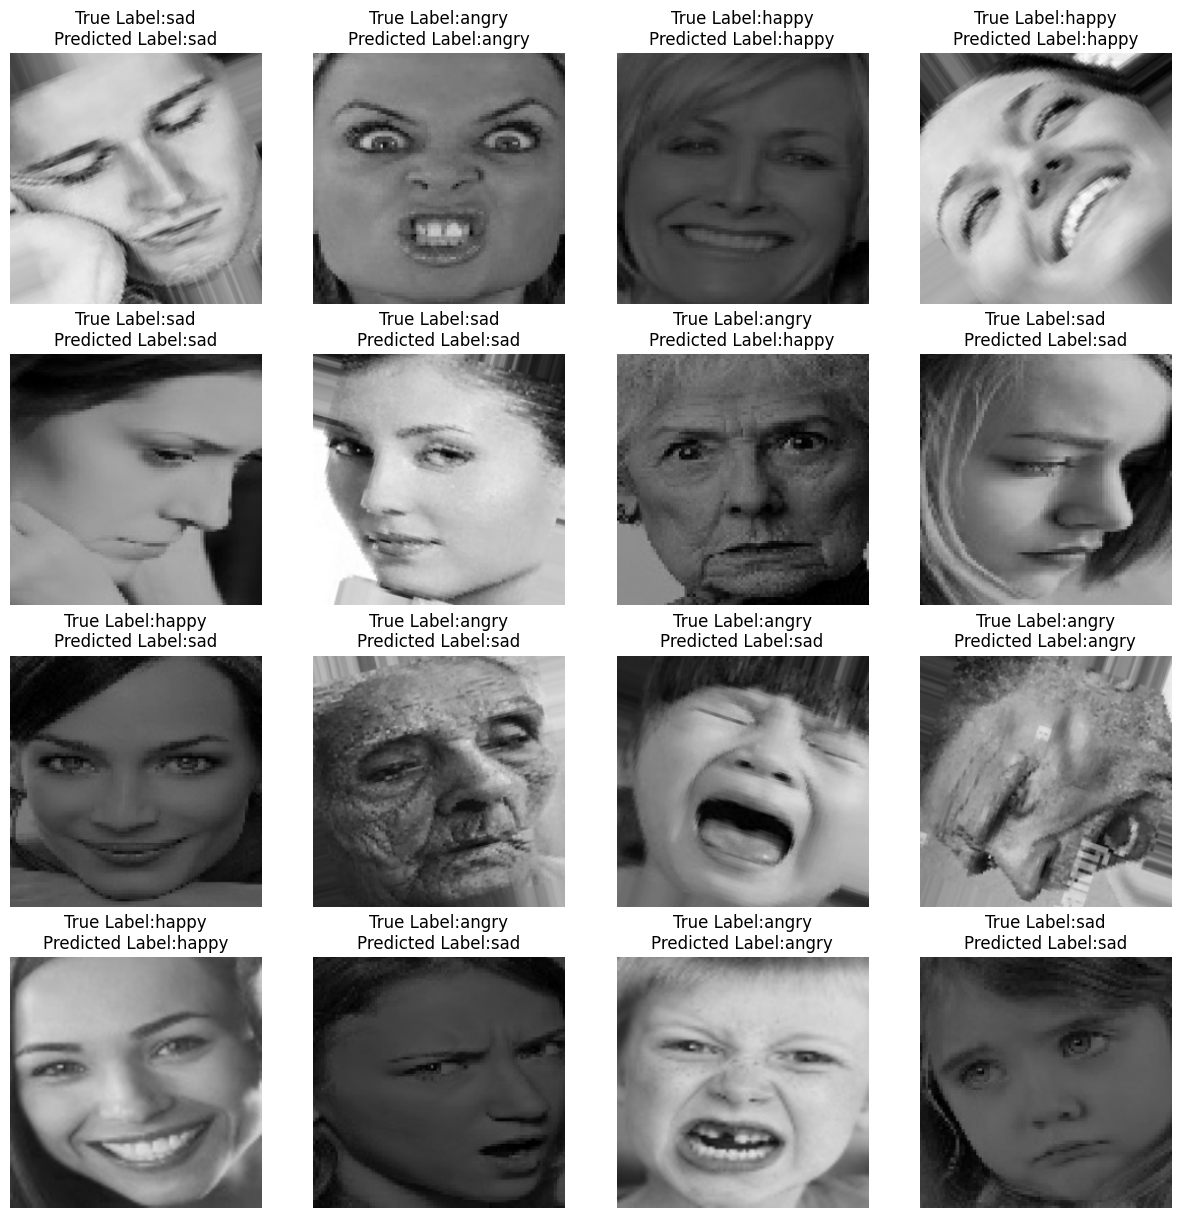

In [ ]:
plt.figure(figsize=(15, 15))

for image, label in val_data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image[i]/255.)
        plt.title("True Label:"+ class_names[np.argmax(label[i])] + "\n" + "Predicted Label:" + class_names[np.argmax(model_emo_best.predict(tf.expand_dims(image[i], axis=0)))])
        plt.axis("off")

## Confusion Matrix

In [ ]:
predicted = []
labels = []
for image, label in val_data:
  predicted.append(model_emo_best.predict(image))
  labels.append(label.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
print(np.argmax(labels[:-1], axis = -1).flatten())    #[:-1] all values except the last
print(np.argmax(predicted[:-1], axis = -1).flatten())

[2 2 0 ... 0 1 0]
[2 2 0 ... 2 1 2]


In [ ]:
predict = np.argmax(predicted[:-1], axis = -1).flatten()
label = np.argmax(labels[:-1], axis = -1).flatten()

[[362  62  89]
 [ 26 917  59]
 [ 38  79 640]]


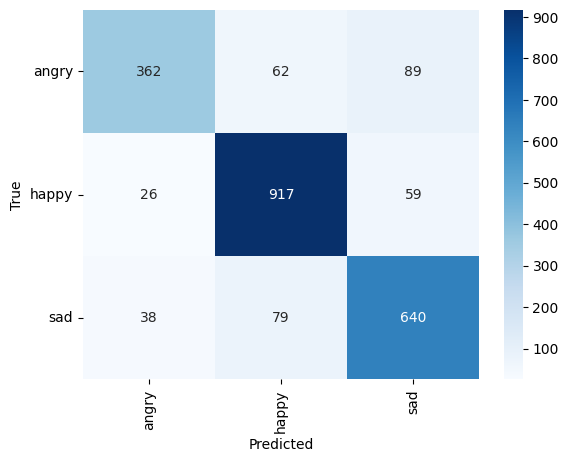

In [ ]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(label, predict)
print(cm)

# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
# show class names instead
plt.xticks(np.arange(3) + 0.5, class_names, rotation=90)
plt.yticks(np.arange(3) + 0.5, class_names, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[[364  62  89]
 [ 26 921  59]
 [ 38  79 640]]


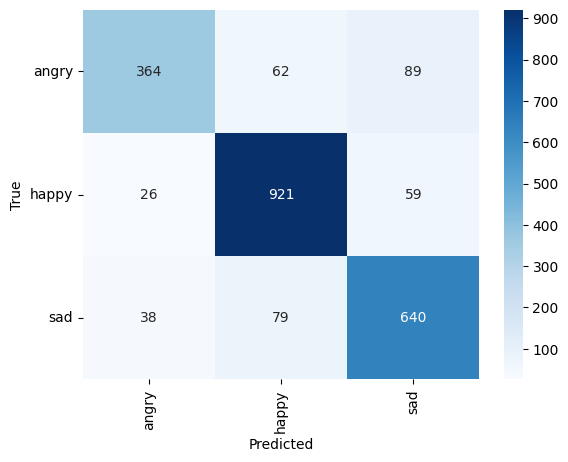

In [ ]:
# all values including the last
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

cm = confusion_matrix(lab, pred)
print(cm)

# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# show class names instead
plt.xticks(np.arange(3) + 0.5, class_names, rotation=90)
plt.yticks(np.arange(3) + 0.5, class_names, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label, predict, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.85      0.71      0.77       513
       happy       0.87      0.92      0.89      1002
         sad       0.81      0.85      0.83       757

    accuracy                           0.84      2272
   macro avg       0.84      0.82      0.83      2272
weighted avg       0.84      0.84      0.84      2272



## Testing

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
import cv2

im = cv2.imread("/content/images.jfif")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256))
im = preprocess_input(im)
im = tf.expand_dims(im, axis=0)
print(class_names[tf.argmax(func_model.predict(im), axis = -1).numpy()[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
angry


## **Function to Resume Training from Latest Checkpoint**
- This way of loading and may overwrite your BestModel, as it just resumed the training from 11 epoch, it doesn't know what is the val accuracy of Your Best model, it just knows the metrics of the last checkpoint (i.e. `emotion_model_epoch_10.keras`) and for it the initial val accuracy for that point is -inf (infinity) till it runs the 1st epoch.
- So, if you want to resume the training of your true best model (i.e. `EmotionModelBest.keras`) then try the alternative method Below.

In [ ]:
import os
import re


def load_latest_checkpoint(checkpoint_dir, pattern=r"EfficientNet_emotion_model_epoch_(\d+)\.keras"):
    """
    Loads the model from the latest checkpoint in the given directory.

    Args:
        checkpoint_dir (str): Directory where checkpoints are stored.
        pattern (str): Regex to capture epoch numbers from filenames.

    Returns:
        model (tf.keras.Model), last_epoch (int)
    """
    # Lists all checkpoint files
    files = os.listdir(checkpoint_dir)

    # To Extract epoch numbers
    epochs = []
    for f in files:
        match = re.match(pattern, f)
        if match:
            epochs.append((int(match.group(1)), f))

    if not epochs:
        raise FileNotFoundError("No checkpoint files found in " + checkpoint_dir)

    # Gets the latest epoch
    last_epoch, last_file = max(epochs, key=lambda x: x[0])
    latest_path = os.path.join(checkpoint_dir, last_file)

    # Loads the  model
    model = tf.keras.models.load_model(latest_path)
    print(f"Loaded model from {latest_path} (epoch {last_epoch})")

    return model, last_epoch


In [ ]:
checkpoint_dir = "/content/drive/MyDrive/EfficientNetEmotionModelCheckpoints"

model_emo, last_epoch = load_latest_checkpoint(checkpoint_dir)

Loaded model from /content/drive/MyDrive/EfficientNetEmotionModelCheckpoints/EfficientNet_emotion_model_epoch_10.keras (epoch 10)


In [ ]:
model_emo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=configuration["learning_rate"]),
    loss="categorical_crossentropy",
    metrics=["accuracy", "top_k_categorical_accuracy", "precision", "recall"]
)

In [ ]:
historyy = model_emo.fit(train_data, validation_data=val_data,
              epochs = last_epoch + 5,        # 10 done → train until 15
              # class_weight = class_weights,
              callbacks = [early_stop, lr_scheduler, checkpoint, best_model_checkpoint],
              initial_epoch = last_epoch    # continue counting from last epoch, starts from 11

              )

Epoch 11/15


KeyboardInterrupt: 

## **Alternactive Method To Continue Training**
- Loads the Best Model with best accuracy from last training and continue training from that point.

In [ ]:
from tensorflow import keras
from tensorflow.keras.metrics import TopKCategoricalAccuracy

# Load the previous best model instead of last-epoch model
best_model_path = "/content/drive/MyDrive/EfficientNetEmotionModelBest.keras"
model_emo = keras.models.load_model(best_model_path)

# to resume training
model_emo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=configuration["learning_rate"]),
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=2, name="top2_acc"), "precision", "recall"]
)


history = model_emo.fit(
    train_data,
    validation_data=val_data,
    epochs= last_epoch + 5,
    initial_epoch=last_epoch,
    callbacks=[early_stop, lr_scheduler, checkpoint, best_model_checkpoint],
    # class_weight=class_weights
)


Epoch 11/15
  1/213 ━━━━━━━━━━━━━━━━━━━━ 2:35:04 44s/step - accuracy: 0.9688 - loss: 0.1166 - precision: 1.0000 - recall: 0.9688 - top2_acc: 0.9688

KeyboardInterrupt: 